# 0. Import modules and data

In [1]:
#from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
from datetime import datetime
from datetime import date
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns 
import warnings
sns.set()
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## Explore a little bit about what the data looks like

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dty

  **The size of training dataset is 1,458,644 * 11, columns are:**
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- trip_duration - duration of the trip in seconds
       
 **625,134*9 for test dataset, columns are** 
- 'id', 'vendor_id'
- 'pickup_datetime'
- 'passenger_count'
- 'pickup_longitude'
- 'pickup_latitude'
- 'dropoff_longitude'
- 'dropoff_latitude'
- 'store_and_fwd_flag'

# 1. data exploration and visualization

## 1.1 trip duration

In [5]:
train.trip_duration.describe()
print(train.trip_duration.max()/3600)

979.5227777777778


The max trip duration was more than 900 hours. 
It's obviously a outlier.
Since we will use RMSLE as the metric of our score, let's transform the trip_duration in to the log form:
log_trip_duration=log(trip_duration+1)
 
The transform help mitigate the effect of outliers. If the value is still enormously big after the log transform, we can tell it is a true outliers with more confidence.

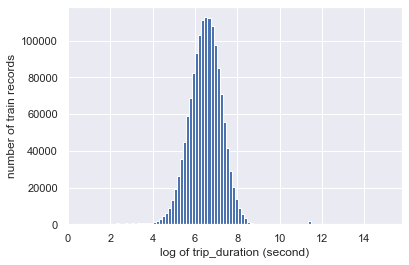

In [6]:
train['log_trip_duration']=np.log(train['trip_duration'].values+1)
#plt.hist(np.log(train['trip_duration'].values+1), bins=100)
plt.hist(train['log_trip_duration'], bins=100)
plt.xlabel('log of trip_duration (second)')
plt.ylabel('number of train records')
plt.show()

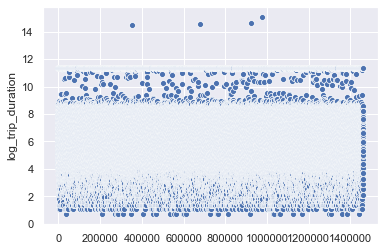

In [7]:
sns.scatterplot(x=train.index,y=train.log_trip_duration)

four obvious outliers are detected. delete them

In [8]:
train=train[train.log_trip_duration<14]

## 1.2 pickup_time vs trip duration

Let's extract month,day,hour from pickup_datetime and if it's weekend/restday to see how it affect trip duration
new columns:
- year
- month
- day
- day_of_year
- pickup_time(hour+minute/60)
- isrestday (1 if it's restday o if not, restday includes weenkend and holiday)

In [9]:
# import holiday info
holiday=pd.read_csv('NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]
def is_restday(dt):
    if dt in holidays or dt.isoweekday()==6 or dt.isoweekday()==7:
        return 1
    else:
        return 0
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])
#train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])
for df in (train,test):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hour']  = df['pickup_datetime'].dt.hour
    df['minute'] = df['pickup_datetime'].dt.minute
    df['pickup_time']=df['pickup_datetime'].dt.hour+df['pickup_datetime'].dt.minute/60
    df['isrestday'] = df['pickup_datetime'].map(is_restday)
    df['day_of_year'] = df['pickup_datetime'].map(lambda x:x.timetuple().tm_yday)
    



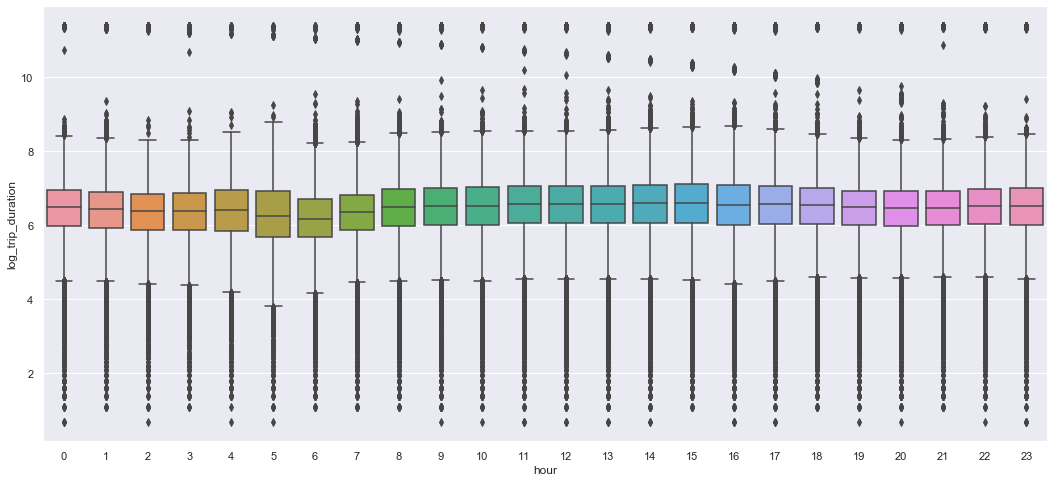

In [10]:
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="hour", y="log_trip_duration", data=train)

#plt.ylim([0,10000])

**AS expected,trip duration is longer in the daytime and shorter at night.**

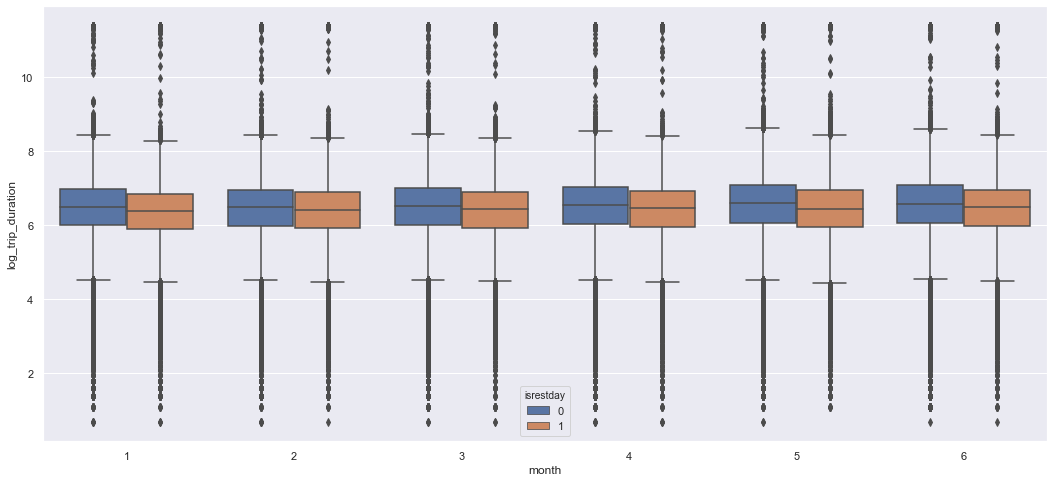

In [11]:
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="month", y="log_trip_duration", data=train,hue='isrestday')

**Trip duration for different months doesn't make a big difference. But trip duration is shorter for rest day.**

## 1.3 passenger_count vs trip duration

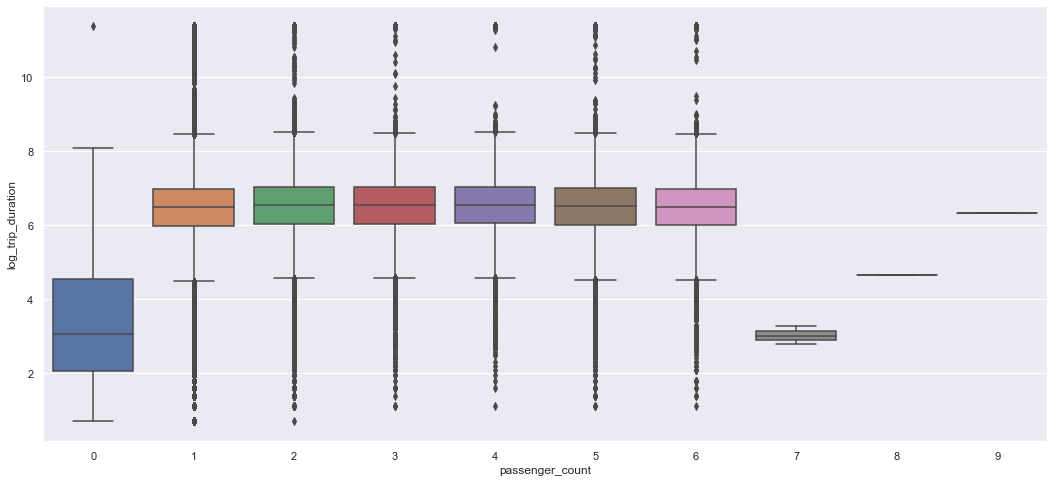

In [12]:
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="passenger_count", y="log_trip_duration", data=train)

**It seems like the number of passenger count doesn't affect the trip duration a lot. But passenger count=0,7,8,9 is questionable**

## 1.4 store_and_fwd_flag vs trip duration

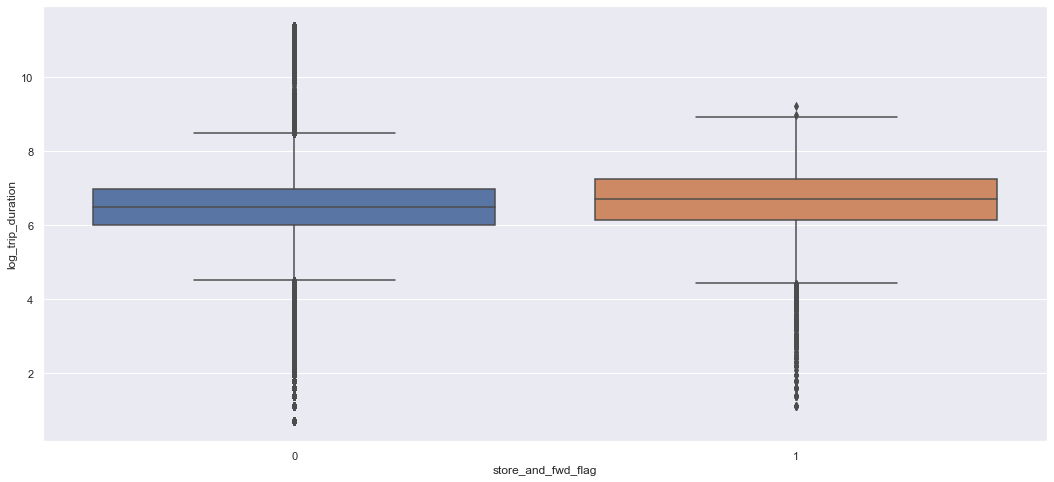

In [13]:
train.store_and_fwd_flag=train.store_and_fwd_flag.map({'N':0,'Y':1})
test.store_and_fwd_flag=test.store_and_fwd_flag.map({'N':0,'Y':1})
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="store_and_fwd_flag", y="log_trip_duration", data=train)

**This feature plays a part**

## 1.5 vendor_id vs trip duration

Two vendor_id got similar graph

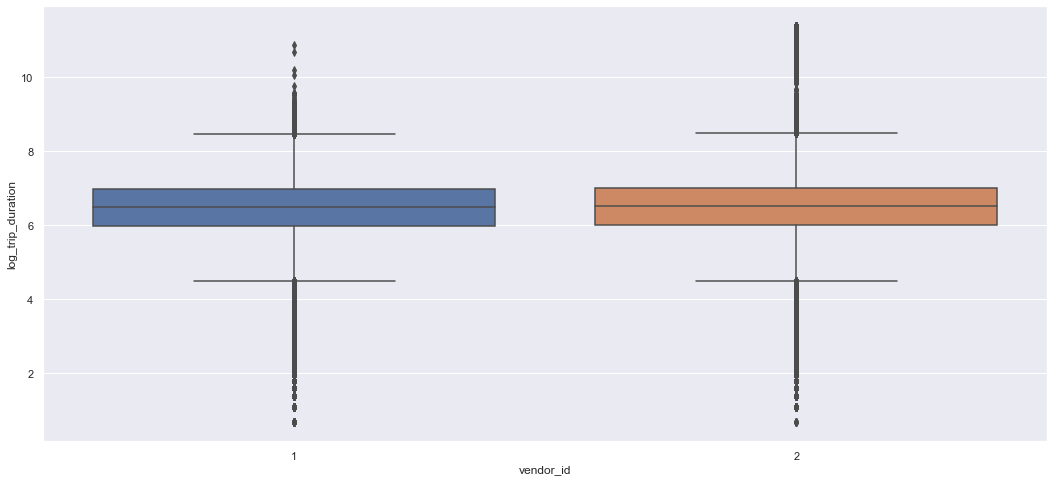

In [14]:
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="vendor_id", y="log_trip_duration", data=train)

# 2 feature extraction

## 2.1 distance 

Intuitively, distance between the start and end point of a trips is the most crucial factor for trip time. So let's calculate the manhattan distance(km) based on pickup and dripoff locations

two methods to calculate distance:
- haversine distance
- manhattan distance


In [15]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
train['m_distance']=dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['h_distance']=haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test['m_distance']=dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['h_distance']=haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)


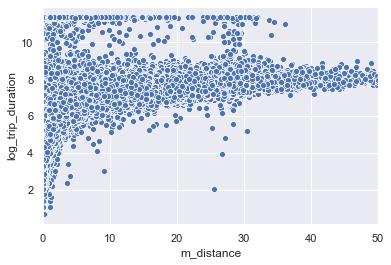

In [16]:
f=sns.scatterplot(x=train.m_distance,y=train.log_trip_duration)
f.set_xlim(0,50)
plt.show()

**As expected, distance shows a strong positive correlation with trip duration**

## 2.2 location feature: k-means clustering
built 10 clusters for both pickup and dropoff locations

In [17]:
#train['pickup_cluster'] = MiniBatchKMeans(n_clusters=10,random_state=0,batch_size=10000).fit_predict(train[['pickup_latitude','pickup_longitude']])
kmeans_pickup=MiniBatchKMeans(n_clusters=10,random_state=0,batch_size=10000).fit(train[['pickup_latitude','pickup_longitude']])
train['pickup_cluster']=kmeans_pickup.predict(train[['pickup_latitude','pickup_longitude']])
test['pickup_cluster']=kmeans_pickup.predict(test[['pickup_latitude','pickup_longitude']])
kmeans_dropoff=MiniBatchKMeans(n_clusters=10,random_state=0,batch_size=10000).fit(train[['dropoff_latitude','dropoff_longitude']])
train['dropoff_cluster']=kmeans_dropoff.predict(train[['dropoff_latitude','dropoff_longitude']])
test['dropoff_cluster']=kmeans_dropoff.predict(test[['dropoff_latitude','dropoff_longitude']])

In [18]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,day,hour,minute,pickup_time,isrestday,day_of_year,m_distance,h_distance,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,14,17,24,17.400000,0,74,1.735433,1.498521,0,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,12,0,43,0.716667,1,164,2.430506,1.805507,8,3
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,19,11,35,11.583333,0,19,8.203575,6.385098,7,3
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,6,19,32,19.533333,0,97,1.661331,1.485498,4,8
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,26,13,30,13.500000,1,86,1.199457,1.188588,0,6


visualize the result of clustering

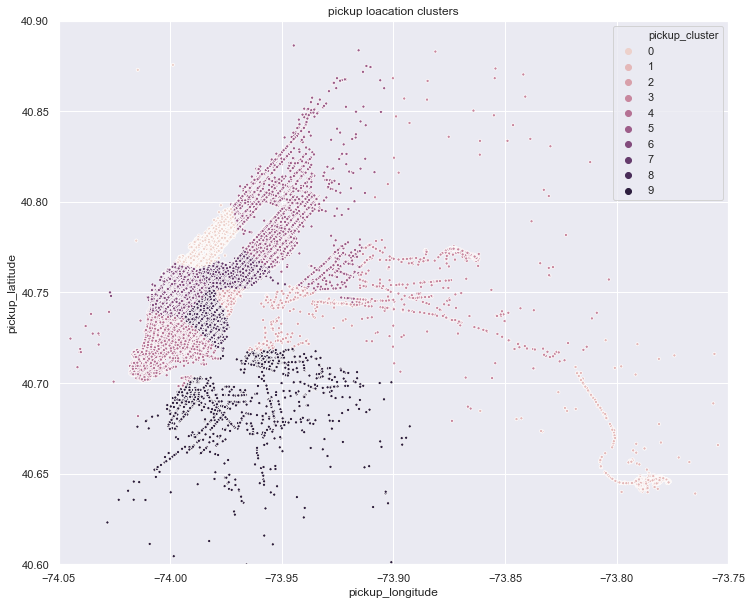

In [19]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=train[:100000],x='pickup_longitude',y='pickup_latitude',hue='pickup_cluster',s=10,legend='full')
plt.xlim([-74.05,-73.75])
plt.ylim([40.6,40.9])
plt.title('pickup loacation clusters')
plt.show()

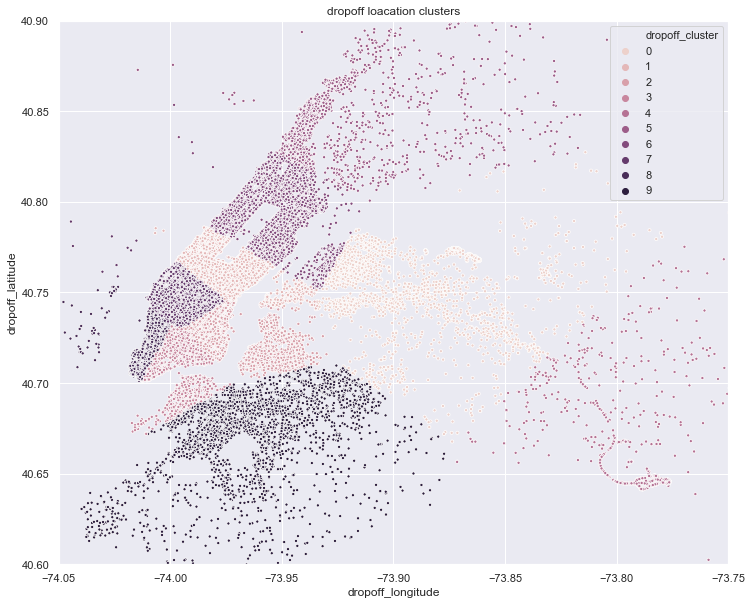

In [20]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=train[:100000],x='dropoff_longitude',y='dropoff_latitude',hue='dropoff_cluster',s=10,legend='full')
plt.xlim([-74.05,-73.75])
plt.ylim([40.6,40.9])
plt.title('dropoff loacation clusters')
plt.show()

# 3 Model training: XGBoost Model

In [21]:
N=100000 # The number of training data we want to use
train_permutation=train.iloc[np.random.permutation(len(train))[:N]]
x=train_permutation.drop(columns=['year','pickup_datetime','dropoff_datetime','id','trip_duration','log_trip_duration'])
y=train_permutation.log_trip_duration
#train=train.drop(columns=['year','pickup_datetime','dropoff_datetime','id','trip_duration','log_trip_duration'])
x_test=test.drop(columns=['year','pickup_datetime','id'])

# train validation split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


Try some different model to see how they perform

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
#from lightgbm.sklearn import LGBMRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#lgbm_model = LGBMRegressor(n_estimators=150,subsample=0.85,subsample_freq=5,learning_rate=0.05)
xgb_model = xgb.XGBRegressor()
rf_model = RandomForestRegressor()
tree_model = DecisionTreeRegressor()
knn_model = KNeighborsRegressor()
ridge_model = Ridge()
lasso_model = Lasso()
models=[('DecisionTree', tree_model),('XGBoost', xgb_model),('RandomForest', rf_model),('KNN', knn_model),('Ridge', ridge_model),('Lasso', lasso_model)]
error=[]
for name,model in models:
    model.fit(x_train,y_train)
    error.append(np.sqrt(mean_squared_error(y_val,model.predict(x_val))))

plot the score for each model

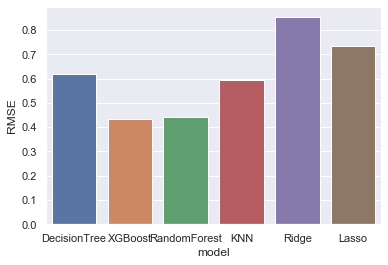

In [23]:
sns.barplot(data=pd.DataFrame({'model':[i[0] for i in models],'RMSE':error}),x='model',y='RMSE')

Tree-based algorithms are obviously better than linear models. XGBoost achieves the best score. Try to optimize the hyperparameters for XGBoost.

In [24]:
from sklearn.model_selection import GridSearchCV
params = {
    "max_depth":[5,8,10], 
    'min_child_wight':[1,10,50],
    "subsample": [0.5,0.8,1],
    'colsample_bytree':[0.5,1],
    'eta':[0.1,0.3]
}
rgr=GridSearchCV(estimator=xgb_model, param_grid=params,scoring='neg_root_mean_squared_error')
rgr.fit(x_train,y_train)
np.sqrt(mean_squared_error(y_val,rgr.predict(x_val)))

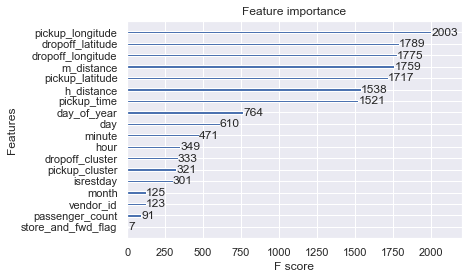

In [38]:
xgb.plot_importance(xgb_model)

In [36]:
x=train.drop(columns=['year','pickup_datetime','dropoff_datetime','id','trip_duration','log_trip_duration'])
y=train.log_trip_duration
xgb_model = xgb.XGBRegressor(max_depth=8,objective='reg:linear',eta=0.3,subsample=0.8,colsample_bytree =0.9,colsample_bylevel=1,min_child_weight=10).fit(x,y)
pre=xgb_model.predict(x_test)
pre=np.exp(pre)-1

[21:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
# output the result
output_path='C:\\Users\\qian\\Desktop\\python\\DATA SCIENTIST\\Kaggle\\new york taxi trip duration\\result.csv'
output=pd.DataFrame({'id':test.id,'trip_duration':pre}).to_csv(output_path, index=False)